In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

np.set_printoptions(precision=4, suppress=True)

In [68]:
 # Get 5 Stock Portfolio
tickers = [
    'AMZN',
    'ATAT',
    'JPM',
    'NIO', 
    'PLTR'
] 

# Get the data
data = yf.download(tickers, period='1y')['Close']

[*********************100%***********************]  5 of 5 completed


In [69]:
returns_df = data.apply(lambda col: (col - col.shift(21)) / col.shift(21)).dropna()

# Calculate the covariance matrix
cov_matrix = returns_df.cov()
cov_matrix

Ticker,AMZN,ATAT,JPM,NIO,PLTR
Ticker,,,,,
AMZN,0.004152,0.002262,0.000796,0.001186,0.006197
ATAT,0.002262,0.017348,-0.000687,0.018310,0.005704
JPM,0.000796,-0.000687,0.002375,-0.001850,0.003412
NIO,0.001186,0.018310,-0.001850,0.050313,0.002220
PLTR,0.006197,0.005704,0.003412,0.002220,0.034664


In [70]:
# get sp500 for market variance
sp500 = yf.download('^GSPC', period='1y')['Close']
sp500_returns = (sp500 - sp500.shift(21)) / sp500.shift(21)
sp500_returns.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [71]:
# Calculate the beta of each stock
def beta(stock):
    df = pd.concat([returns_df[stock], sp500_returns], axis=1).dropna()
    cov = df.cov().iloc[0, 1]
    var = df.var().iloc[1]
    return cov / var

In [72]:
betas = {stock: beta(stock) for stock in data.columns}
betas

{'AMZN': np.float64(1.533232537013114),
 'ATAT': np.float64(1.991900844734132),
 'JPM': np.float64(0.8960591489299166),
 'NIO': np.float64(1.5567560534046099),
 'PLTR': np.float64(3.2116659048301006)}

In [78]:
# Get monthly average returns for all stocks
def monthly_expected_returns(col):
    # Calculate 1-month returns for the column (21 trading days in a month)
    returns = (data[col] - data[col].shift(21)) / data[col].shift(21).dropna()
    # Return the mean of the 1-month returns, dropping NaN values
    return returns.mean()

# Dictionary comprehension to calculate monthly expected returns for each stock
monthly_expected = {
    stock: monthly_expected_returns(stock) for stock in data.columns
}

# Display the results
monthly_expected

{'AMZN': np.float64(0.0333455907125655),
 'ATAT': np.float64(0.04714461910950438),
 'JPM': np.float64(0.03547409139032302),
 'NIO': np.float64(-0.02791383095256694),
 'PLTR': np.float64(0.14746208148301315)}

In [74]:
rf = 0.05717  # 10 year treasury yield
mu = list(monthly_expected.values())  # monthly expected returns
cov_m = cov_matrix
betas_ls = list(betas.values())
n = len(mu)
rm = sp500_returns.mean()

# Objective Function with betas
def neg_sharpe_with_betas(w: list, mu=mu, cov_m=cov_m, rf=rf, betas_ls=betas_ls, rm=rm):
    w = np.array(w)
    mu = np.array(mu)
    betas_ls = np.array(betas_ls)
    
    returns_portfolio = np.dot(w, mu)
    vol_portfolio = np.sqrt(np.dot(w.T, np.dot(cov_m, w)))
    
    # Adjust returns with betas
    beta_adjustment = np.dot(w, betas_ls) * (rm - rf)
    adjusted_returns = returns_portfolio + beta_adjustment
    
    return -(adjusted_returns - rf) / vol_portfolio

# Constraints
def check_sum(w):
    return np.sum(w) - 1

cons = {'type': 'eq', 'fun': check_sum}
bound = [(0.05, 0.5) for _ in range(n)]

# Initial Guess
w0 = [1/n for _ in range(n)]

# Optimize
result = optimize.minimize(neg_sharpe_with_betas, w0, constraints=cons, bounds=bound)
optimized_weights = result.x

output = pd.DataFrame(
    index = data.columns,
    data= {'Weight': optimized_weights},
    )
output.index.name = 'Stock'
output

C:\Users\Gong Jr\.conda\envs\StockAnalysis\Lib\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\Gong Jr\.conda\envs\StockAnalysis\Lib\site-packages\scipy\optimize\_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\Gong Jr\.conda\envs\StockAnalysis\Lib\site-packages\scipy\optimize\_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


,Weight
Stock,
AMZN,0.05
ATAT,0.35
JPM,0.05
NIO,0.05
PLTR,0.50


In [75]:
sum(result.x)

np.float64(1.0)

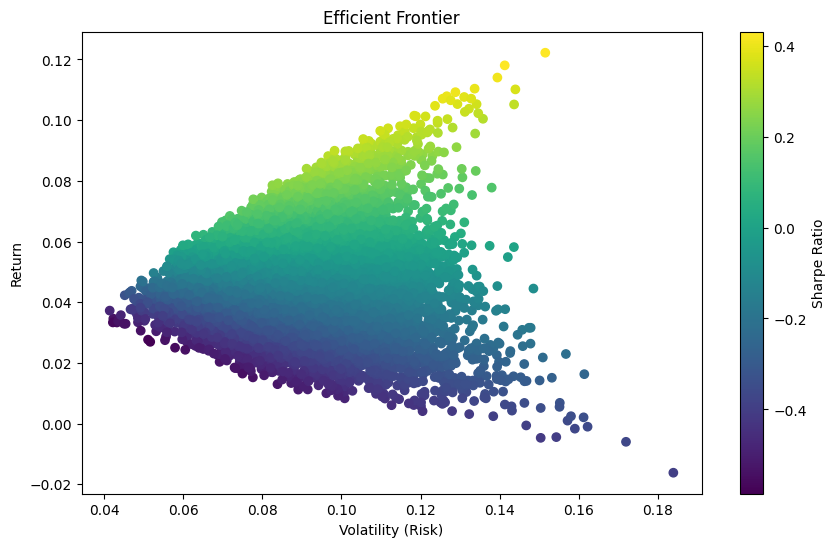

In [76]:
# Stats for Efficient Frontier
def portfolio_stats(weights, mu, cov_matrix):
    returns = np.dot(weights, mu)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

num_portfolios = 10000 
results = np.zeros((3, num_portfolios)) 
weights_record = []

for i in range(num_portfolios): 
    weights = np.random.random(n) 
    weights /= np.sum(weights) 
    weights_record.append(weights) 
    portfolio_return, portfolio_volatility = portfolio_stats(weights, mu, cov_m) 
    results[0,i] = portfolio_volatility 
    results[1,i] = portfolio_return 
    results[2,i] = (portfolio_return - rf) / portfolio_volatility # Sharpe ratio

plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


In [77]:
# Adjust weights to selected dot in the efficient frontier (return \approx 0.06, volatility \approx 0.085)
target_return = 0.08 # Example target return 
target_volatility = 0.06 # Example target volatility

# Create Objective Function
def target_diff(weights, mu, cov_matrix, target_return, target_volatility):
    portfolio_return, portfolio_volatility = portfolio_stats(weights, mu, cov_matrix)
    return (portfolio_return - target_return)**2 + (portfolio_volatility - target_volatility)**2

# Constraints
def check_sum(weights):
    return np.sum(weights) - 1

cons = {'type': 'eq', 'fun': check_sum}
bound = [(0.05, 0.5) for _ in range(n)]  # Adjusted bounds with max weight

# Initial Guess
w0 = [1/n for _ in range(n)]

# Optimize
result = optimize.minimize(target_diff, w0, args=(mu, cov_m, target_return, target_volatility), constraints=cons, bounds=bound)
optimized_weights = result.x

output = pd.DataFrame(
    index = data.columns,
    data= {'Weight': optimized_weights},
    )
output.index.name = 'Stock'
output


,Weight
Stock,
AMZN,0.180578
ATAT,0.050000
JPM,0.445959
NIO,0.050000
PLTR,0.273464
